In [68]:
fidx = 'irv2_'
midx = '2'

# using results from versions of ens_oof.ipynb
mnames = ['irv2_b8']
weights = [1]

threshold = 0.51
nfold = 20

sub_dir = './sub/'

print(fidx,midx,threshold,nfold)
for m,w in zip(mnames,weights):
    print(w,m)
import numpy as np
print('sum of weights',sum(np.array(weights)))
# assert(len(mnames)==len(weights))

irv2_ 2 0.51 20
1 irv2_b8
sum of weights 1


In [69]:
glist = ['iv3_b6','iv3_b9','irv2_b8']
blist = ['blend_0459']
tlist = ['iv3_a4']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(blist)
print(tlist)
print(klist)

gpct = 95.
gscale = 0.1

['iv3_b6', 'iv3_b9', 'irv2_b8']
['blend_0459']
['iv3_a4']
['resnet34_46', 'resnet50', 'resnet34']


In [70]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [71]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [72]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [73]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [74]:
test_df.columns

Index(['Predicted'], dtype='object')

In [75]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [76]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                    
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/irv2_b8_0_mm.pkl
1.3838965267367376e-87 0.15448957121181017 1.0
(11702, 28) 1.3838965267367376e-87 0.15448957121181017 1.0

./sub/irv2_b8_1_mm.pkl
1.3838965267367376e-87 0.1507280108161117 1.0
(11702, 28) 1.3838965267367376e-87 0.1507280108161117 1.0
[[1.    0.762]
 [0.762 1.   ]]

./sub/irv2_b8_2_mm.pkl
1.3838965267367376e-87 0.15445421330619247 1.0
(11702, 28) 1.3838965267367376e-87 0.15445421330619247 1.0
[[1.    0.802]
 [0.802 1.   ]]

./sub/irv2_b8_3_mm.pkl
1.3838965267367376e-87 0.149388926518588 1.0
(11702, 28) 1.3838965267367376e-87 0.149388926518588 1.0
[[1.    0.828]
 [0.828 1.   ]]
irv2_b8 4 (11702, 28) 1.3838965267367376e-87 0.15226518046317555 1.0 0.13460153331542837


In [77]:
test_df.columns

Index(['Predicted', 'irv2_b8'], dtype='object')

In [78]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [79]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
r = np.corrcoef(f)
print(r)

['irv2_b8']
1.0


In [80]:
if len(mnames) > 1:
    d = pd.DataFrame(r, columns=mnames)
    d['id'] = mnames
    d.set_index('id',inplace=True)
    del d.index.name

    sns.clustermap(d)


    # import scipy.cluster.hierarchy as hc
    # from matplotlib import pyplot
    # link = hc.linkage(d.values, method='centroid')
    # o1 = hc.leaves_list(link)

    # mat = d.iloc[o1,:]
    # mat = mat.iloc[:, o1[::-1]]
    # pyplot.imshow(mat)

In [81]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 1)
flat.csv


In [82]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(1, 11702, 28)


In [83]:
weights = np.array(weights)
print(weights)

[1]


In [84]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [85]:
print(ens[1])

[0.986 0.    0.    0.5   0.084 1.    0.264 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.489 0.558 0.    0.1   0.    0.    0.168 1.    0.    0.   ]


In [86]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [87]:
# desired class proportions from lb probing
eps = 0.01
desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : eps,
9 : eps,
10 : eps,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : eps,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : eps,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : eps,
25 : 0.222493888,
26 : 0.028806584,
27 : eps
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.01, 9: 0.01, 10: 0.01, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.01, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.01, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.01, 25: 0.222493888, 26: 0.028806584, 27: 0.01}


In [88]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.51
0 0.3624 0.7200 Nucleoplasm
1 0.0438 0.0715 Nuclear membrane
2 0.0753 0.2241 Nucleoli
3 0.0593 0.1000 Nucleoli fibrillar center
4 0.0753 0.0947 Nuclear speckles
5 0.0753 0.2538 Nuclear bodies
6 0.0438 0.1032 Endoplasmic reticulum
7 0.0753 0.1811 Golgi apparatus
8 0.0100 0.0003 Peroxisomes
9 0.0100 0.0007 Endosomes
10 0.0100 0.0005 Lysosomes
11 0.0438 0.0605 Intermediate filaments
12 0.0438 0.0423 Actin filaments
13 0.0142 0.0288 Focal adhesion sites
14 0.0438 0.0747 Microtubules
15 0.0100 0.0001 Microtubule ends
16 0.0288 0.0451 Cytokinetic bridge
17 0.0142 0.0218 Mitotic spindle
18 0.0288 0.0851 Microtubule organizing center
19 0.0593 0.1348 Centrosome
20 0.0100 0.0034 Lipid droplets
21 0.1261 0.4836 Plasma membrane
22 0.0288 0.0513 Cell junctions
23 0.0753 0.2162 Mitochondria
24 0.0100 0.0124 Aggresome
25 0.2225 0.7439 Cytosol
26 0.0288 0.0148 Cytoplasmic bodies
27 0.0100 0.0000 Rods & rings


In [89]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [0.726 0.702 0.731 0.697 0.672 0.731 0.708 0.719 0.594 0.594 0.593 0.681 0.644 0.709 0.712 0.593
 0.681 0.677 0.723 0.713 0.61  0.744 0.7   0.727 0.675 0.744 0.609 0.592]
Fractions:  [0.616 0.048 0.117 0.061 0.081 0.075 0.046 0.103 0.001 0.001 0.001 0.037 0.041 0.016 0.057 0.
 0.019 0.017 0.04  0.072 0.007 0.    0.029 0.117 0.012 0.    0.025 0.   ]
Fractions (th = 0.5):  [0.989 0.673 0.941 0.79  0.818 0.93  0.793 0.91  0.011 0.008 0.007 0.712 0.558 0.416 0.583 0.013
 0.666 0.323 0.694 0.906 0.058 0.948 0.653 0.927 0.129 0.995 0.324 0.002]


In [90]:
# custom thresholds to match lb proportions
thresholds = np.linspace(0.9, 0.1, 100001)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.9000 0.3624 0.6290 Nucleoplasm
1 0.9000 0.0438 0.0471 Nuclear membrane
2 0.9000 0.0753 0.1419 Nucleoli
3 0.8616 0.0593 0.0594 Nucleoli fibrillar center
4 0.7491 0.0753 0.0753 Nuclear speckles
5 0.9000 0.0753 0.1423 Nuclear bodies
6 0.9000 0.0438 0.0455 Endoplasmic reticulum
7 0.9000 0.0753 0.1061 Golgi apparatus
8 0.1000 0.0100 0.0020 Peroxisomes
9 0.1000 0.0100 0.0018 Endosomes
10 0.1000 0.0100 0.0015 Lysosomes
11 0.7500 0.0438 0.0463 Intermediate filaments
12 0.5012 0.0438 0.0439 Actin filaments
13 0.9000 0.0142 0.0162 Focal adhesion sites
14 0.9000 0.0438 0.0572 Microtubules
15 0.1000 0.0100 0.0020 Microtubule ends
16 0.7500 0.0288 0.0293 Cytokinetic bridge
17 0.7499 0.0142 0.0143 Mitotic spindle
18 0.9000 0.0288 0.0427 Microtubule organizing center
19 0.9000 0.0593 0.0723 Centrosome
20 0.2500 0.0100 0.0115 Lipid droplets
21 0.9000 0.1261 0.3595 Plasma membrane
22 0.8806 0.0288 0.0289 Cell junctions
23 0.9000 0.0753 0.1295 Mitochondria
24 0.7500 0.0100 0.0103 Aggresome
25 0.9000

In [91]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]


In [92]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 2.781746709964109 7.0


In [93]:
print(sum(xps==0)/pred.shape[0])

0.00256366433088361


In [94]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 0 2 3
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 7
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 0 24 25
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0 21 25
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 0 2 3 4
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23 25
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 0 1 4 25
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 0 12 19 21 25
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'sub

In [95]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/irv2_2.csv


In [96]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 7360 prop 0.6290
1 Nuclear membrane count 551 prop 0.0471
2 Nucleoli count 1661 prop 0.1419
3 Nucleoli fibrillar center count 695 prop 0.0594
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 1665 prop 0.1423
6 Endoplasmic reticulum count 532 prop 0.0455
7 Golgi apparatus count 1242 prop 0.1061
8 Peroxisomes count 23 prop 0.0020
9 Endosomes count 21 prop 0.0018
10 Lysosomes count 18 prop 0.0015
11 Intermediate filaments count 542 prop 0.0463
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 189 prop 0.0162
14 Microtubules count 669 prop 0.0572
15 Microtubule ends count 23 prop 0.0020
16 Cytokinetic bridge count 343 prop 0.0293
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 500 prop 0.0427
19 Centrosome count 846 prop 0.0723
20 Lipid droplets count 135 prop 0.0115
21 Plasma membrane count 4207 prop 0.3595
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 1515 prop 0.1295
24 Aggresome coun

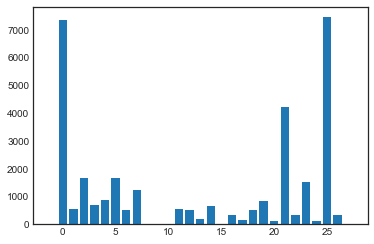

In [97]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [98]:
from sklearn.metrics import f1_score

# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [99]:
f1_sub(fname,'sub/protein_classification.csv')

0.5177734035961794

In [100]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.5263319821149799

In [101]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5096791029598895

In [102]:
f1_sub(fname,'sub/blend_InceptionV3_InceptionResNetV2_DenseNet201_2.csv')

0.567974629810614

In [103]:
f1_sub(fname,'sub/iv3_0.csv')

0.5101940581089002

In [104]:
f1_sub(fname,'sub/irv2_0.csv')

0.5198126990928319

In [105]:
f1_sub(fname,'sub/irv2_1.csv')

0.5398673093212817

In [106]:
f1_sub(fname,'sub/resnet34_0.csv')

0.5315632259995169

In [107]:
f1_sub(fname,'sub/resnet50_0.csv')

0.5323244045483806

In [108]:
f1_sub(fname,'sub/resnet4.csv')

0.5510819490035408

In [109]:
f1_sub(fname,'sub/resnet5.csv')

0.5227864286491913

In [110]:
f1_sub(fname,'sub/resnet6.csv')

0.5572829246189258

In [111]:
f1_sub(fname,'sub/resnet7.csv')

0.5322873190187846

In [112]:
f1_sub(fname,'sub/se_resnet1.csv')

0.5951344775678072

In [113]:
f1_sub(fname,'sub/se_resnet2.csv')

0.5886827831124012

In [114]:
f1_sub(fname,'sub/se_resnext6.csv')

0.5199714906165834

In [115]:
f1_sub(fname,'sub/se_resnext9.csv')

0.5679447387260578

In [116]:
f1_sub(fname,'sub/se_resnext10.csv')

0.5798129721542619

In [117]:
f1_sub(fname,'sub/ens0.csv')

0.5294290349359542

In [118]:
f1_sub(fname,'sub/ens1.csv')

0.5478691615539696

In [119]:
f1_sub(fname,'sub/ens2.csv')

0.5480868567500098

In [120]:
f1_sub(fname,'sub/ens6.csv')

0.6028710360266565

In [121]:
f1_sub(fname,'sub/ens7.csv')

0.5541964269122353

In [122]:
f1_sub(fname,'sub/ens8.csv')

0.6218602576799643

In [123]:
f1_sub(fname,'sub/ens9.csv')

0.660431695857482

In [124]:
f1_sub(fname,'sub/ens10.csv')

0.6565337697115728

In [125]:
f1_sub(fname,'sub/ens11.csv')

0.6496098989831527

In [126]:
f1_sub(fname,'sub/ens12.csv')

0.6585940166423595

In [127]:
f1_sub(fname,'sub/ens13.csv')

0.5081265372214193

In [128]:
f1_sub(fname,'sub/ens14.csv')

0.661377221128822

In [129]:
f1_sub(fname,'sub/ens15.csv')

0.6621441470839088

In [130]:
f1_sub(fname,'sub/ens16.csv')

0.6678652785423808

In [131]:
print(fname)

sub/irv2_2.csv
